In [27]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import *
from keras import optimizers

In [28]:
image_width = 32
image_height = 32
num_classes = 4

In [29]:
model = Sequential()
model.add(Flatten(input_shape=(image_height, image_width, 3)))
model.add(Dense(num_classes))
model.add(Activation("softmax"))

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_1 (Dense)             (None, 4)                 12292     
                                                                 
 activation_1 (Activation)   (None, 4)                 0         
                                                                 
Total params: 12,292
Trainable params: 12,292
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.optimizers.Adam(learning_rate=1e-3),
              metrics=["accuracy"])

In [32]:
train_data_dir = "Training/"
test_data_dir = "Testing/"

In [33]:
from keras.preprocessing import image
img = image.load_img(train_data_dir + "glioma_tumor/gg (1).jpg", 
                     target_size=(image_width, image_height))

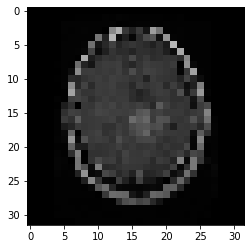

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(img)

In [35]:
def normalize_pixels(image):
    return image / 127.5 - 1

In [36]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(preprocessing_function=normalize_pixels)

In [37]:
batch_size = 64

train_generator = datagen.flow_from_directory(
                    train_data_dir,
                    target_size=(image_width, image_height),
                    batch_size=batch_size,
                    class_mode="categorical",
                    shuffle=True)

test_generator = datagen.flow_from_directory(
                    test_data_dir,
                    target_size=(image_width, image_height),
                    batch_size=batch_size,
                    class_mode="categorical",
                    shuffle=False)

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [38]:
train_generator.class_indices

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

In [39]:
train_generator.class_indices.items()

dict_items([('glioma_tumor', 0), ('meningioma_tumor', 1), ('no_tumor', 2), ('pituitary_tumor', 3)])

In [40]:
# Dictionary comprehension, reverse indices and names

index2class = {v:k for k,v in train_generator.class_indices.items()}
index2class

{0: 'glioma_tumor', 1: 'meningioma_tumor', 2: 'no_tumor', 3: 'pituitary_tumor'}

In [41]:
import warnings
warnings.filterwarnings("ignore")

In [43]:
# Uczenie

model.fit(x=train_generator,
         epochs=10,
         workers=3)

Epoch 1/10
45/45 [==============================] - 2s 34ms/step - loss: 0.8954 - accuracy: 0.6376
Epoch 2/10
45/45 [==============================] - 2s 33ms/step - loss: 0.8101 - accuracy: 0.6711
Epoch 3/10
45/45 [==============================] - 2s 33ms/step - loss: 0.7516 - accuracy: 0.7132
Epoch 4/10
45/45 [==============================] - 2s 33ms/step - loss: 0.7265 - accuracy: 0.7132
Epoch 5/10
45/45 [==============================] - 2s 34ms/step - loss: 0.6719 - accuracy: 0.7505
Epoch 6/10
45/45 [==============================] - 2s 33ms/step - loss: 0.6324 - accuracy: 0.7659
Epoch 7/10
45/45 [==============================] - 2s 33ms/step - loss: 0.6121 - accuracy: 0.7753
Epoch 8/10
45/45 [==============================] - 2s 34ms/step - loss: 0.6109 - accuracy: 0.7679
Epoch 9/10
45/45 [==============================] - 2s 34ms/step - loss: 0.5663 - accuracy: 0.7822
Epoch 10/10
45/45 [==============================] - 2s 35ms/step - loss: 0.5415 - accuracy: 0.8056


In [44]:
model.evaluate_generator(test_generator, steps=len(test_generator))

2022-04-16 12:37:14.939295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[1.7967811822891235, 0.5355330109596252]

In [58]:
# Test - no tumor imagae

testImg = image.load_img(test_data_dir + "no_tumor/image(1).jpg", 
                     target_size=(image_width, image_height))

testImgArr = image.img_to_array(testImg)
print(testImgArr.shape)

testImgArr = normalize_pixels(testImgArr)
testImgArr = np.expand_dims(testImgArr, axis=0)

testImgArr.shape

(32, 32, 3)


(1, 32, 32, 3)

In [59]:
pred = model.predict(testImgArr)
print(pred)
print(index2class[np.argmax(pred[0])])

[[8.6318009e-04 2.0974457e-01 7.8934193e-01 5.0355091e-05]]
no_tumor


In [ ]:
# Test - using generators